In [2]:
%matplotlib inline
from sklearn import neighbors
from nltk.stem.wordnet import WordNetLemmatizer
import string
import seaborn as sns 
from sklearn.metrics import accuracy_score
from sklearn import ensemble
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
from sklearn import decomposition
import scipy
import sklearn
import spacy
from sklearn.model_selection import train_test_split
import re
import os
import gensim
from gensim.models import word2vec
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import MeanShift, estimate_bandwidth
from nltk.corpus import gutenberg, stopwords
from collections import Counter

Our goal is to be able to confidently organize unlabeled news articles. This model will be inportant to help news orginizations with archives that are so volumous it would not be practical for employees to organize them by hand.

We are training our model with BBC news articles due to two factors. One, is that BBC is a highly respected news outlet with large amounts of content. And, two, this corpus comes with labels that can help us to analyze our unsupervised output as well as allow us to train a supervised model. Below you will find our order of operations and I will walk you through our procedures as they occur in the notebook.

## Order of operations

1. Import corpus of documents and document labels
- Tokenize all words, remove punctuation and convert words to their lemmas
- We will begin modelig by using two different methods of feature generation: TFIDF and CBOW word2vec
- We will test our clusters for density and well as cluster separation
- We will look at ground truth for the articles in each cluster to achieve two things
  - Utilizing the information to make an educated decision on which type of article that our         cluster is identifying 
  - Testing our certainty level by investigating how frequently our cluster selects the most         frequent ground truth label
- We will then perform supervised learning with KNN to see how well the unsupervised results compare
- We will display our findings by comparing the clusters with a scatterplot

 Here we are importing our documents and ground truth labels

In [3]:
df_tfidf_train = pd.DataFrame()
df_w2v_train = pd.DataFrame()
df_tfidf_test = pd.DataFrame()
df_w2v_test = pd.DataFrame()
article_list = []
ground_truth = []
categories = ['business', 'entertainment', 'politics', 'sport',  'tech']
for i, category in enumerate(categories):
    # is i coming first convention?
    for root, dirs, files in os.walk(os.path.join("./bbc_text",category)):
        # Are "root, dirs, files specifically related to os.walk or are they our names?
        # What is the ordering method for situations like this where we have 3 after the for
        # statement?
        for file in sorted(files):
            # Why did we sort the files?
            ground_truth.append(i)
            try:
                # I need a brief reminder about 'with' statement. Does it read as, "With 'do
                # something here' being 'f', then append 'f'
                with open(os.path.join(root,file),"r",encoding='utf-8') as f:
                    article_list.append(f.read())
            except:
                with open(os.path.join(root,file),"r",encoding='iso-8859-1') as f:
                    article_list.append(f.read())
print(article_list[0])
# When I tried to copy and paste yours it gave me this same empty list.              

Ad sales boost Time Warner profit

Quarterly profits at US media giant TimeWarner jumped 76% to $1.13bn (£600m) for the three months to December, from $639m year-earlier.

The firm, which is now one of the biggest investors in Google, benefited from sales of high-speed internet connections and higher advert sales. TimeWarner said fourth quarter sales rose 2% to $11.1bn from $10.9bn. Its profits were buoyed by one-off gains which offset a profit dip at Warner Bros, and less users for AOL.

Time Warner said on Friday that it now owns 8% of search-engine Google. But its own internet business, AOL, had has mixed fortunes. It lost 464,000 subscribers in the fourth quarter profits were lower than in the preceding three quarters. However, the company said AOL's underlying profit before exceptional items rose 8% on the back of stronger internet advertising revenues. It hopes to increase subscribers by offering the online service free to TimeWarner internet customers and will try to sign up AOL

In [4]:
%ls bbc_text

README.TXT     entertainment/ sport/
business/      politics/      tech/


We are now converting the words to spacy tokens

In [6]:
nlp = spacy.load('en')
articles_tokenized = nlp.pipe(article_list)

We are eliminating grammar, stop words, and punctuation and are converting all words to their lemmas or root words. We are also creating a list of tokenized documents as well as sentenced. 

In [ ]:
# Converting tokens to sentences and lemmas. Assuring punctuation is scrubbed
sentences = []
docs = [] # Docs for later use
for doc in articles_tokenized:
    docs.append(doc)
    for sentence in doc.sents:
        sentence = [
            token.lemma_
            for token in sentence
            if not token.is_stop
            and not token.is_punct
        ]
        sentences.append(sentence)


#print(sentences)
print('We have {} sentences'.format(len(sentences)))

In [ ]:
X_train_sentences, X_test_sentences = train_test_split(sentences, test_size=0.25)

In [ ]:
X_train_docs, X_test_docs, y_train_docs, y_test_docs = train_test_split(docs, ground_truth, test_size=0.25)

In [ ]:
X_train_articles, X_test_articles, y_train_articles, y_test_articles = train_test_split(article_list, ground_truth, test_size=0.25)

In [ ]:
X_train_text = [doc.text for doc in X_train_docs]
X_test_text = [doc.text for doc in X_test_docs]

In [312]:
# Make it so they are reusable
def generate_labels(df):
    predicted_clusters = {}
    for cluster_number in df.iloc[:, 0].unique():
        df_sub = df[df.iloc[:, 0] == cluster_number]
        counts = df_sub.groupby(df.columns[1]).count()
        #print(counts)
        predicted_label = counts.iloc[:, 0].argmax()
        predicted_clusters[cluster_number] = predicted_label
    return predicted_clusters

In [313]:
def generate_label_names(df):
    pred_label = df['predicted_label']
    labels = []
    for prediction in pred_label:
        if prediction == 0:
            labels.append('business')
        if prediction == 1:
            labels.append('entertainment')
        if prediction == 2:
            labels.append('politics')
        if prediction == 3:
            labels.append('sports')
        if prediction == 4:
            labels.append('tech')
    return labels

Here we are generating our features with CBOW word2vec. We determinded our window and the minimum count for words to be used in the feature set by trial and error

In [314]:
#--------Cbow---------
cbow_model = word2vec.Word2Vec(
    X_train_sentences,     
    min_count=5,   # Minimum word count threshold.
    window=5,      # Number of words around target word to consider.
    sg=0,          # CBOW
    sample=1e-3 ,  
    size=100,      # when referring to vector legnth is that dimensions?
    hs=1           
)

Here we are testing for similarity of words and looking deeper into the proximity of the vectors. Below we test whether the formula "man + woman - boy = ?" to see what it the model returns. In an ideal situation it would return "girl". 
We are also testing a variety of different words to determine which word is deemed most similar.
The results are displayed below the cell. We tested terms that would be similar to each other but would most likely fall into different clusters like "politician" and "musician".
We also tested how similar words are that should be identified as similar such as "study" and "research". Finally we tested whether the model would select the least similar word from a group of four. This test resulted in a subjectively accurate selection four of the five times. 

In [315]:
vocab = cbow_model.wv.vocab.keys()

print(cbow_model.wv.most_similar(positive=['woman', 'man'], negative=['boy']))
# Testing to see which words it will group with 'planet'
#print('Similarity to planet')
print('1:')
print(cbow_model.wv.most_similar('politician'))
print('2:')
print(cbow_model.wv.most_similar('scientist'))
print('3:')
print(cbow_model.wv.most_similar('artist'))
print('4:')
print(cbow_model.wv.most_similar('musician'))

# Testing for similarity 
#print('Cosine similatrity analysis:')
#print('study / research')
print('5:')
print(cbow_model.wv.similarity('study', 'research'))
#print('court / field')
print('6:')
print(cbow_model.wv.similarity('computer', 'tool'))
print('7:')
print(cbow_model.wv.similarity('musician', 'artist'))
print('8:')
print(cbow_model.wv.similarity('phone', 'device'))

# Testing to see if it will leave out the right word (looking for 'dinosaur')
#print('Which doesnt fit?')
#print('bat / bird / dinosaur / bee')
print(cbow_model.doesnt_match("man woman plane dog".split()))
print(cbow_model.doesnt_match("rock human computer dog".split()))
print(cbow_model.doesnt_match("rock human rocket dog".split()))
print(cbow_model.doesnt_match("car human rocket dog".split()))
print(cbow_model.doesnt_match("car human rocket boat".split()))

[('hurdle', 0.6479326486587524), ('10,000', 0.6109898686408997), ('60', 0.6098575592041016), ('5,000', 0.6005403995513916), ('m', 0.5838732719421387), ('800', 0.5662125945091248), ('earn', 0.5632321834564209), ('fine', 0.555415153503418), ('4x100', 0.5548432469367981), ('400', 0.545910120010376)]
1:
[('backing', 0.8860893249511719), ('criticism', 0.8684194684028625), ('colleague', 0.868348240852356), ('yes', 0.8667871952056885), ('answer', 0.8657523393630981), ('crass', 0.8534051179885864), ('obligation', 0.8463348150253296), ('enforcement', 0.8435054421424866), ('jewish', 0.8407377004623413), ('opinion', 0.8392961621284485)]
2:
[('script', 0.8968690633773804), ('principle', 0.8778873682022095), ('jim', 0.8697720170021057), ('complex', 0.8611780405044556), ('gun', 0.8425371050834656), ('fancy', 0.8399375677108765), ('restrict', 0.839179277420044), ('technical', 0.837169885635376), ('poorly', 0.835829496383667), ('disadvantage', 0.8342361450195312)]
3:
[('soul', 0.9077479243278503), ('r

In this cell we are creating a vector list so that we can use the vectors as the input for our model. We are converting them into arrays so that they are able to be procesed by the model.

In [316]:
def create_vector_list(array_shape, X):
    vector_list = []
    for article in X:
        article_vector = np.zeros_like(array_shape)
        for word in article:
            word = word.lemma_ # is the _ after lemma to tell it a certin output style?
            if word in cbow_model.wv:
                vector = cbow_model.wv[word]
                article_vector += vector
        norm = normalize(article_vector.reshape(1, -1))
        norm = norm.flatten()
        vector_list_train.append(norm)
    return vector_list

In [317]:
# Will this work?
array_shape = cbow_model.wv['human']
X_train_w2v_tst = create_vector_list(array_shape, X_train_docs)
X_test_w2v_tst = create_vector_list(array_shape, X_test_docs)

In [318]:
x = cbow_model.wv['human']
print(len(x))
vector_list_train = []
X_train_w2v = vector_list_train
for article in X_train_docs:
    article_vector = np.zeros_like(x)
    for word in article:
        word = word.lemma_ # is the _ after lemma to tell it a certin output style?
        if word in cbow_model.wv:
            vector = cbow_model.wv[word]
            article_vector += vector
    norm = normalize(article_vector.reshape(1, -1))
    norm = norm.flatten()
    vector_list_train.append(norm)
print(X_train_w2v[0])

100
[-0.10163597  0.06196163 -0.06739511 -0.09020794  0.00398664 -0.15250887
  0.06487608 -0.12741601 -0.13131678  0.13934165  0.11883402 -0.04411813
  0.04860513  0.09440438  0.16206747 -0.0269784  -0.15176022 -0.12163032
  0.18435821  0.00867045 -0.1135703   0.10854971  0.04984051 -0.00066759
 -0.02674315  0.22801584 -0.10274254  0.12348481 -0.04475388  0.02230245
 -0.08379339 -0.02109511 -0.03186174  0.16961037 -0.09540003  0.1117531
  0.01824461 -0.07913387 -0.04520315 -0.011938   -0.02167527  0.1441309
  0.03429836  0.17603734  0.01269839  0.01683525 -0.02307229 -0.07851724
 -0.03149116  0.10184038 -0.14661025 -0.01333573 -0.03257419  0.08241693
 -0.05327448 -0.06976554  0.15638544  0.09549756 -0.13223259 -0.00324592
 -0.12949261  0.03503614  0.05177028 -0.12335191  0.0499597  -0.0515377
  0.02641366  0.06431809 -0.03375869  0.143114    0.09924459 -0.02580441
 -0.22399645 -0.07679445 -0.06962156  0.09219582  0.13723546  0.07591461
 -0.01227786 -0.12100838  0.23692797 -0.0385934  -

In [319]:
x = cbow_model.wv['human']
print(len(x))
vector_list_test = []
X_test_w2v = vector_list_test
for article in X_test_docs:
    article_vector = np.zeros_like(x)
    for word in article:
        word = word.lemma_ # is the _ after lemma to tell it a certin output style?
        if word in cbow_model.wv:
            vector = cbow_model.wv[word]
            article_vector += vector
    norm = normalize(article_vector.reshape(1, -1))
    norm = norm.flatten()
    vector_list_test.append(norm)
print(vector_list_test[0])

100
[-0.08271331  0.09638442 -0.05684152 -0.07659648  0.03656899 -0.14179608
 -0.00610131 -0.07704935 -0.08333877  0.11476549  0.04417501 -0.00867689
  0.03342016  0.13061942  0.19102137 -0.09722098 -0.07887115 -0.12269948
  0.12748273  0.00835117 -0.10407868  0.10890844  0.09068085  0.01396666
 -0.00401089  0.13929841 -0.06468967  0.07349794 -0.03757415 -0.01590693
 -0.14965855  0.01452237 -0.06495982  0.14260978 -0.0563046   0.10308105
 -0.02110095 -0.07180952 -0.07888969 -0.06212923  0.02173942  0.12393685
 -0.04543114  0.16410108 -0.06271366  0.05919416 -0.02891461 -0.11167807
 -0.04311287  0.09299545 -0.21125911 -0.03118133 -0.02517921  0.12020861
 -0.0434412  -0.08532986  0.17127787  0.07488441 -0.09794358  0.00194534
 -0.12044793  0.12037563  0.19822533 -0.12171124  0.01879674 -0.06061492
  0.00557055  0.04816177 -0.03710365  0.12294525  0.11877683  0.01558487
 -0.2467445  -0.04821456 -0.03604031  0.10033061  0.18512966  0.04597824
 -0.01197215 -0.053435    0.2138752  -0.0052806

We are training our model and are testing which number of clusters is yeilds the most dense and separated clusters. We are also testing each model for accuracy by analyzing its performance next to the ground truth labels.

In [340]:
number_clusters = [2, 3, 5, 8, 10, 15, 20]
w2v_cluster_models = []
df_w2v_analysis = pd.DataFrame()

for num in number_clusters:
    model = KMeans(n_clusters=num).fit(X_train_w2v)
    prediction_w2v = model.predict(X_train_w2v)
    df_w2v_analysis.loc[num,'Silhouette Score'] = metrics.silhouette_score(X_train_w2v, prediction_w2v, metric='euclidean')
    df_w2v_analysis.loc[num,'Calinski Harabaz Index'] = metrics.calinski_harabaz_score(X_train_w2v, prediction_w2v)
    df_w2v_analysis.loc[num,'K-Means Objective'] = model.score(X_train_w2v)
    df_w2v_analysis.loc[num,'Adjusted Rand Score'] = metrics.adjusted_rand_score(y_train_docs, prediction_w2v)
df_w2v_analysis

,Silhouette Score,Calinski Harabaz Index,K-Means Objective,Adjusted Rand Score
2,0.256199,601.265241,-309.454277,0.324714
3,0.263323,569.285277,-250.107432,0.501259
5,0.312880,616.852836,-169.559767,0.789029
8,0.251651,493.912886,-136.610299,0.606738
10,0.233583,445.098265,-123.280400,0.549809
15,0.198989,356.625990,-104.749475,0.407085
20,0.188422,304.696652,-93.318883,0.329130


In [341]:
model_w2v = KMeans(n_clusters=5).fit(X_train_w2v)
prediction_w2v = model_w2v.predict(X_train_w2v)

In [342]:
prediction_w2v_test = model_w2v.predict(X_test_w2v)

In [343]:
df_w2v_train['pred'] = prediction_w2v
df_w2v_train['labels'] = y_train_docs

In [344]:
len(prediction_w2v_test)
#len(y_test_docs)

557

In [345]:
df_w2v_test['pred'] = prediction_w2v_test
df_w2v_test['labels'] = y_test_docs

We are now attempting semisupervised learning by finding which ground truth label our clusters most frequently predict and are assigning that ground truth label to the cluster. We are also investigating how often frequently the ground truth label is selected in each cluster. This will allow us to detremine how much confidence we can have in our clustering model and its selection.

In [346]:
label_map = generate_labels(df_w2v_train)
df_w2v_train['predicted_label'] = df_w2v_train.iloc[:, 0].map(lambda x: label_map[x])
df_w2v_train.head(50)

,pred,labels,predicted_label,label_names
0,3,3,3,sports
1,4,4,4,tech
2,1,1,1,entertainment
3,0,0,0,business
4,1,4,1,entertainment
5,3,3,3,sports
6,0,0,0,business
7,4,4,4,tech
8,4,1,4,tech
9,2,0,2,politics


In [347]:
label_names = generate_label_names(df_w2v_train)
df_w2v_train['label_names'] = label_names
df_w2v_train.head()

,pred,labels,predicted_label,label_names
0,3,3,3,sports
1,4,4,4,tech
2,1,1,1,entertainment
3,0,0,0,business
4,1,4,1,entertainment


In [348]:
df_w2v_test['predicted_label'] = df_w2v_test.iloc[:, 0].map(lambda x: label_map[x])
df_w2v_test.head(50)

,pred,labels,predicted_label,label_names
0,1,1,1,entertainment
1,3,3,3,sports
2,0,0,0,business
3,0,0,0,business
4,4,2,4,tech
5,4,4,4,tech
6,0,0,0,business
7,3,3,3,sports
8,0,0,0,business
9,0,0,0,business


In [349]:
label_names_test = generate_label_names(df_w2v_test)
df_w2v_test['label_names'] = label_names_test
df_w2v_test.head()

,pred,labels,predicted_label,label_names
0,1,1,1,entertainment
1,3,3,3,sports
2,0,0,0,business
3,0,0,0,business
4,4,2,4,tech


In [350]:
df_w2v_test['predicted_label']
accuracy_score(df_w2v_test['labels'], df_w2v_test['predicted_label'])

0.8922800718132855

In [351]:
(df_w2v_test['labels'] == df_w2v_test['predicted_label']).mean()

0.8922800718132855

Here we we are training our supervised KNN model using a similar technique as the Kmeans. We are testing multiple counts of identifiers to see which gives us the most accurate results. We will be able to compare our unsupervised model's success to the success of the KNN model. 

In [1]:
num_neighbors = [2, 5, 10, 15, 20, 22, 25, 30, 40]
df_w2v_knn = pd.DataFrame()
for neighbor in num_neighbors:
    knn_w2v = neighbors.KNeighborsClassifier(n_neighbors=neighbor)
    knn_w2v.fit(X_train_w2v, y_train_docs)
    # Convert test section to vectors here
    y_pred_knn_w2v = knn_w2v.predict(X_test_w2v)
    #print(neighbor)
    #print('Percentage accuracy')
    #print(knn_w2v.score(X_test_w2v, y_test_docs))
    df_w2v_knn.loc[neighbor,'K-Means Objective'] = knn_w2v.score(X_test_w2v, y_test_docs)
df_w2v_knn

NameError: name 'pd' is not defined

In [360]:
num_estimators = [2, 5, 10, 15, 17, 18, 20, 40, 80, 100, 150, 200, 300]
df_w2v_rfc = pd.DataFrame()
for estimator in num_estimators:
    rfc_w2v = ensemble.RandomForestClassifier(n_estimators=estimator, max_depth=10)
    rfc_w2v.fit(X_train_w2v, y_train_docs)
    y_pred_rfc_w2v = rfc_w2v.predict(X_test_w2v)
    print(estimator)
    print('Percentage accuracy')
    print(rfc_w2v.score(X_test_w2v, y_test_docs)) 
    #df_w2v_rfc.loc[num,'K-Means Objective'] = rfc_w2v.score(X_test_w2v, y_test_docs)
#df_w2v_rfc

2
Percentage accuracy
0.872531418312
5
Percentage accuracy
0.929982046679
10
Percentage accuracy
0.931777378815
15
Percentage accuracy
0.940754039497
17
Percentage accuracy
0.947935368043
18
Percentage accuracy
0.94434470377
20
Percentage accuracy
0.946140035907
40
Percentage accuracy
0.947935368043
80
Percentage accuracy
0.953321364452
100
Percentage accuracy
0.955116696589
150
Percentage accuracy
0.951526032316
200
Percentage accuracy
0.94973070018
300
Percentage accuracy
0.951526032316


Below is a visualization of the clusters we generated followed by a visualization of the ground truth article groups

/Users/kylehoward/Desktop/Thinkful/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


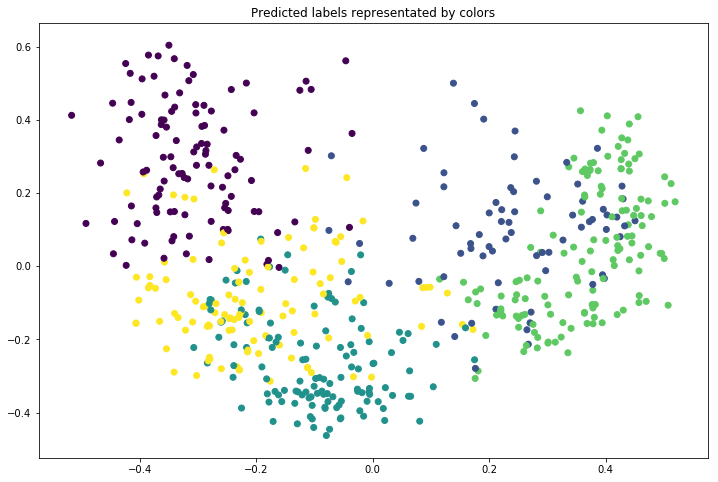

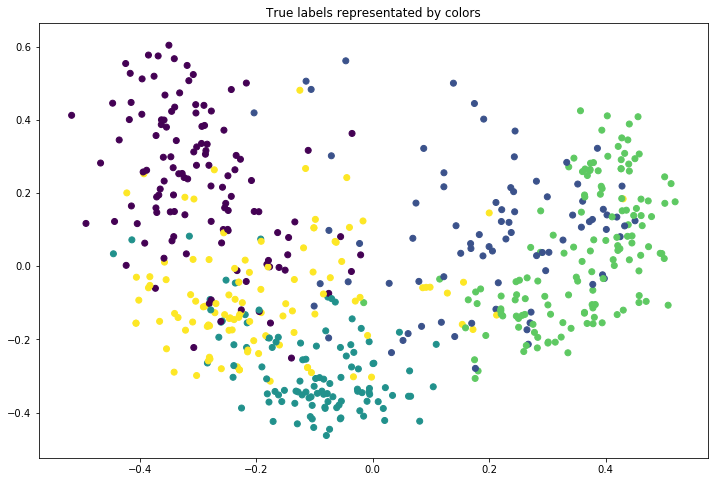

In [281]:
pca = decomposition.PCA(n_components=2)
pca.fit(np.array(X_test_w2v))
X_2 = pca.transform(X_test_w2v)

plt.figure(figsize=(12,8))
plt.scatter(X_2[:,0], X_2[:,1],c=df_w2v_test['predicted_label'])
plt.title('Predicted labels representated by colors')
plt.legend()
plt.figure(figsize=(12,8))
plt.scatter(X_2[:,0], X_2[:,1],c=df_w2v_test['labels'])
plt.title('True labels representated by colors')

Here we are representing our semi-supervised model's selections compared to the ground truth labels with a heatmap

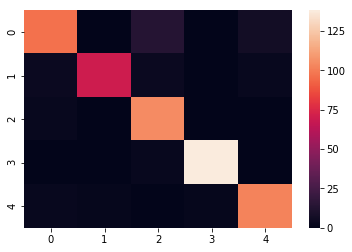

In [264]:
confusion_matrix_w2v = confusion_matrix(df_w2v_test['labels'], df_w2v_test['predicted_label'])
sns.heatmap(confusion_matrix_w2v)

We will now run the same procedures with tfidf to see if we can outperform the word2vec. All procedures are the same except for the tfidf feature generation. For our parameters we normalized the paragraphs so that longer paragraphs don't carry more weight then our shorter, we  set word frequency to 2 to assure that obscure terms don't skew the model, and we dropped words that occur in more then a quarter of the articles.

In [282]:
#-------------------------------------------tfidf-----------------------------------------------


vectorizer = TfidfVectorizer(max_df=0.25,          # drop words that occur in more than a quarter of the articles
                             min_df=2,             # only use words that appear at least twice
                             stop_words='english', # picking list of stop words
                             lowercase=True,       # convert everything to lower case
                             max_features=3000,
                             use_idf=True,         # use inverse document frequencies in our weighting
                             norm=u'l2',           # Treat longer and shorter paragraphs equally
                             smooth_idf=True       # Prevent divide-by-zero errors
                            )


# Applying the vectorizer
article_list_tfidf_train = vectorizer.fit_transform(X_train_text)
article_list_tfidf_test = vectorizer.transform(X_test_text)
print("Number of features: %d" % article_list_tfidf_train.get_shape()[1])

# Reshape the vectorizer output to be legible 
article_list_tfidf_csr = article_list_tfidf_train.tocsr()

# number of articles
n = article_list_tfidf_csr.shape[0]

# Making a list of dictionaries, one per article
tfidf_bypara = [{} for _ in range(0,n)]

# List of features
terms = vectorizer.get_feature_names()




print('Original article:', article_list[5])
print('Tf_idf vector:', article_list_tfidf_train[5])

Number of features: 3000
Original article: Japan narrowly escapes recession

Japan's economy teetered on the brink of a technical recession in the three months to September, figures show.

Revised figures indicated growth of just 0.1% - and a similar-sized contraction in the previous quarter. On an annual basis, the data suggests annual growth of just 0.2%, suggesting a much more hesitant recovery than had previously been thought. A common technical definition of a recession is two successive quarters of negative growth.

The government was keen to play down the worrying implications of the data. "I maintain the view that Japan's economy remains in a minor adjustment phase in an upward climb, and we will monitor developments carefully," said economy minister Heizo Takenaka. But in the face of the strengthening yen making exports less competitive and indications of weakening economic conditions ahead, observers were less sanguine. "It's painting a picture of a recovery... much patchier 

In [339]:
number_clusters = [2, 3, 5, 8, 10, 15, 20]
X_train_tfidf = article_list_tfidf_train
X_test_tfidf = article_list_tfidf_test
df_tfidf_analysis = pd.DataFrame()
X_train_tfidf_dense = X_train_tfidf.toarray()
X_test_tfidf_dense = X_test_tfidf.toarray()
for num in number_clusters:
    model_tfidf = KMeans(n_clusters=num).fit(X_train_tfidf)
    prediction_tfidf = model_tfidf.predict(X_train_tfidf)
    model_tfidf_dense = KMeans(n_clusters=num).fit(X_train_tfidf_dense)
    prediction_tfidf_dense = model_tfidf.predict(X_train_tfidf_dense)
    #print(num)
    #print('Silhouette Score')
    #print(metrics.silhouette_score(X_train_tfidf, prediction_tfidf, metric='euclidean'))
    df_tfidf_analysis.loc[num,'Silhouette Score'] = metrics.silhouette_score(X_train_tfidf, prediction_tfidf, metric='euclidean')
    df_tfidf_analysis.loc[num,'Calinski Harabaz Index'] = metrics.calinski_harabaz_score(X_train_tfidf_dense, prediction_tfidf_dense)
    df_tfidf_analysis.loc[num,'K-Means Objective'] = model_tfidf.score(X_train_tfidf_dense)
    df_tfidf_analysis.loc[num,'Adjusted Rand Score'] = metrics.adjusted_rand_score(y_train_docs, prediction_tfidf)
df_tfidf_analysis

,Silhouette Score,Calinski Harabaz Index,K-Means Objective,Adjusted Rand Score
2,0.011058,18.873733,-1599.594040,-0.000708
3,0.012532,18.154315,-1583.190856,-0.000230
5,0.017901,16.228068,-1556.942955,-0.001313
8,0.020338,13.384979,-1531.285610,0.000596
10,0.022219,12.322422,-1516.292345,-0.000680
15,0.027259,10.689979,-1483.410134,-0.000633
20,0.026323,9.289224,-1461.223370,-0.000402


In [284]:
model_tfidf = KMeans(n_clusters=5).fit(X_train_tfidf)
prediction_tfidf = model_tfidf.predict(X_train_tfidf)

In [285]:
prediction_tfidf_test = model_tfidf.predict(X_test_tfidf)

In [286]:
df_tfidf_train['pred'] = prediction_tfidf
df_tfidf_train['labels'] = y_train_docs

In [287]:
df_tfidf_test['pred'] = prediction_tfidf_test
df_tfidf_test['labels'] = y_test_docs

In [288]:
label_map = generate_labels(df_tfidf_train)
df_tfidf_train['predicted_label'] = df_tfidf_train.iloc[:, 0].map(lambda x: label_map[x])
df_tfidf_train.head(50)

,pred,labels,predicted_label,label_names
0,2,1,1,tech
1,3,2,2,tech
2,0,2,0,tech
3,1,3,3,sports
4,3,2,2,politics
5,4,4,4,tech
6,2,1,1,entertainment
7,2,1,1,entertainment
8,3,2,2,politics
9,2,1,1,entertainment


In [289]:
label_names = generate_label_names(df_tfidf_train)
df_tfidf_train['label_names'] = label_names
df_tfidf_train.head()

,pred,labels,predicted_label,label_names
0,2,1,1,entertainment
1,3,2,2,politics
2,0,2,0,business
3,1,3,3,sports
4,3,2,2,politics


In [290]:
label_map = generate_labels(df_tfidf_test)
df_tfidf_test['predicted_label'] = df_tfidf_test.iloc[:, 0].map(lambda x: label_map[x])
df_tfidf_test.head(50)

,pred,labels,predicted_label,label_names
0,0,2,0,sports
1,2,1,1,sports
2,3,2,2,sports
3,2,1,1,sports
4,0,0,0,sports
5,0,2,0,sports
6,2,1,1,sports
7,1,3,3,sports
8,3,2,2,sports
9,1,3,3,sports


In [291]:
label_names = generate_label_names(df_tfidf_test)
df_tfidf_test['label_names'] = label_names
df_tfidf_test.head()

,pred,labels,predicted_label,label_names
0,0,2,0,business
1,2,1,1,entertainment
2,3,2,2,politics
3,2,1,1,entertainment
4,0,0,0,business


In [292]:
df_tfidf_test['predicted_label']
accuracy_score(df_tfidf_test['labels'], df_tfidf_test['predicted_label'])

0.90664272890484743

In [293]:
num_neighbors = [2, 5, 10, 15, 20, 40, 43, 50, 60, 80]
for neighbor in num_neighbors:
    knn_tfidf = neighbors.KNeighborsClassifier(n_neighbors=neighbor)
    knn_tfidf.fit(X_train_tfidf, y_train_docs)
    y_pred_knn_tfidf = knn_tfidf.predict(X_test_tfidf)
    print('Percentage accuracy')
    print(neighbor)
    print(knn_tfidf.score(X_test_tfidf, y_test_docs))

Percentage accuracy
2
0.910233393178
Percentage accuracy
5
0.935368043088
Percentage accuracy
10
0.953321364452
Percentage accuracy
15
0.940754039497
Percentage accuracy
20
0.946140035907
Percentage accuracy
40
0.953321364452
Percentage accuracy
43
0.953321364452
Percentage accuracy
50
0.951526032316
Percentage accuracy
60
0.958707360862
Percentage accuracy
80
0.955116696589


In [294]:
num_estimators = [2, 5, 10, 15, 17, 18, 20, 40, 80, 90, 100, 110, 120, 130, 140, 150, 200, 300]
for estimator in num_estimators:
    rfc_tfidf = ensemble.RandomForestClassifier(n_estimators=estimator, max_depth=10)
    rfc_tfidf.fit(X_train_tfidf, y_train_docs)
    y_pred_rfc_tfidf = rfc_tfidf.predict(X_test_tfidf)
    print('Percentage accuracy')
    print(estimator)
    print(rfc_tfidf.score(X_test_tfidf, y_test_docs)) 

Percentage accuracy
2
0.680430879713
Percentage accuracy
5
0.798922800718
Percentage accuracy
10
0.886894075404
Percentage accuracy
15
0.915619389587
Percentage accuracy
17
0.897666068223
Percentage accuracy
18
0.917414721724
Percentage accuracy
20
0.913824057451
Percentage accuracy
40
0.937163375224
Percentage accuracy
80
0.94973070018
Percentage accuracy
90
0.946140035907
Percentage accuracy
100
0.931777378815
Percentage accuracy
110
0.955116696589
Percentage accuracy
120
0.946140035907
Percentage accuracy
130
0.947935368043
Percentage accuracy
140
0.946140035907
Percentage accuracy
150
0.94973070018
Percentage accuracy
200
0.94434470377
Percentage accuracy
300
0.946140035907


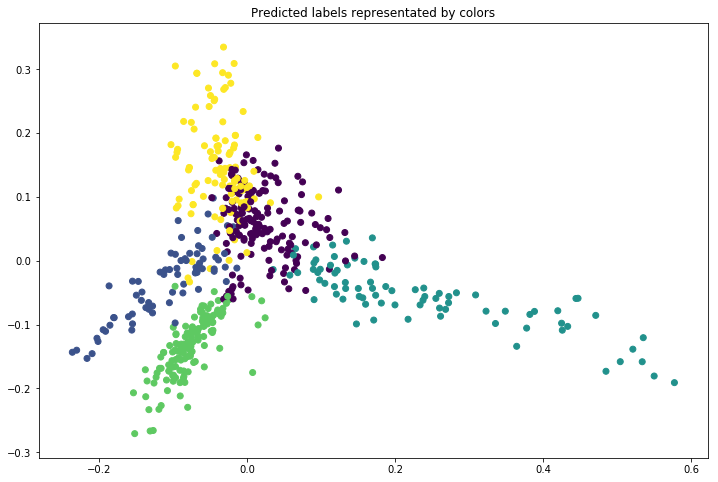

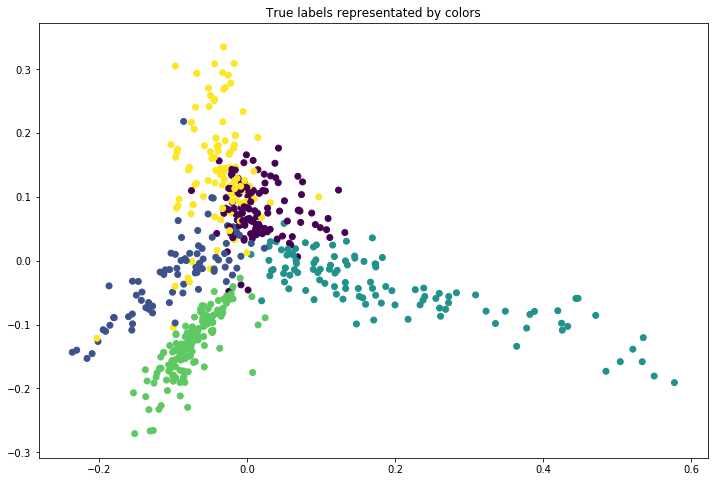

In [296]:
# Should I use a similar loop as we did before to convert this into a list of arrays?
pca = decomposition.PCA(n_components=2)
pca.fit(X_test_tfidf_dense)
X_2 = pca.transform(X_test_tfidf_dense)

plt.figure(figsize=(12,8))
plt.scatter(X_2[:,0], X_2[:,1],c=df_tfidf_test['predicted_label'])
plt.title('Predicted labels representated by colors')
plt.figure(figsize=(12,8))
plt.scatter(X_2[:,0], X_2[:,1],c=df_tfidf_test['labels'])
plt.title('True labels representated by colors')

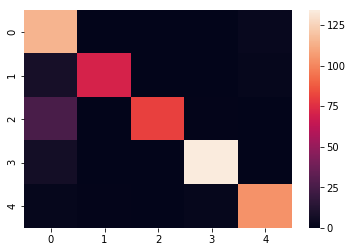

In [297]:
confusion_matrix_tfidf = confusion_matrix(df_tfidf_test['labels'], df_tfidf_test['predicted_label'])
sns.heatmap(confusion_matrix_tfidf)

In [ ]:
print('TFIDF Confusion Matrix')
print(confusion_matrix_tfidf)

## Conclusion:

After running unsupervised clustering, semisupervised clustering from those results, and running K-Nearest Neighbor and Random Forrest Classification we have a strong conclusion:
- Due to the Silhouette scores and Calinski Harabaz Index we can determing that the most successful clusters are generated when we specify that we want five clusters. This makes sense as there are five ground truth labels
- Semi-supervised Word2Vec slightly underperforms tfidf due to how frequently it correctly identifies the ground truth labels. The scores are .8923 to .9064 respectively. 
- When we compare the strongest performing supervised learing categories for Word2Vec we get .9551 for RFC compared to .8923 semi-supervised exhibiting only a .0628 difference 
- When we compare the strongest performing supervised learing categories for tfidf we get .9587 for KNN compared to .9064 semi-supervised exhibiting only a .0523 difference 

We can now determine that our method of semi-supervised clustering is successful 90.6% of the time and we can use this model to cluster unlabeled documents of similar nature to our training and test sets. We can also determine toat our semi-supervised model performs 94.5% as well as a supervised model using the same inputs.
